## Stokes Flow in Periodic Channel with Robin boundary.

In [1]:
import sys
sys.path.append('/home/emastr/phd/')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"#"last_expr_or_assign"

import torch
import time
import numpy as np
import matplotlib.pyplot as plt
from stokes2d.robin_solver_scaled import testSolve, solveRobinStokes_fromFunc
from util.basis_scaled import ScaleShiftedBasis as SSBasis
from util.basis_scaled import ScaleShiftedBasisProduct as SSBasisProduct 
from util.basis_scaled import FourBasis, BasisProduct, ChebBasis
#from stokes2d.robin_solver import testSolve, solveRobinStokes_fromFunc
from util.plot_tools import *
from boundary_solvers.geometry import MacroGeom

## Multiscale Problem

We define a multiscale problem as follows. The PDE is a non-slip zero forcing Stokes flow Problem

\begin{equation}
\Delta u  - \nabla p = 0, \qquad \qquad \nabla \cdot u = 0   \qquad \text{inside}\quad \Omega
\end{equation}

with the boundary conditions

\begin{equation}
u = g,\qquad \text{on}\quad\partial\Omega
\end{equation}

the boundary is a two-dimensional pipe with corners at (0,-1) and (1,1), and a micro scale boundary:

In [38]:
u,v,uTrue,vTrue = testSolve(51,31, plot=False,tol=1e-5, dom=[[0, 2.],[0,2.]])

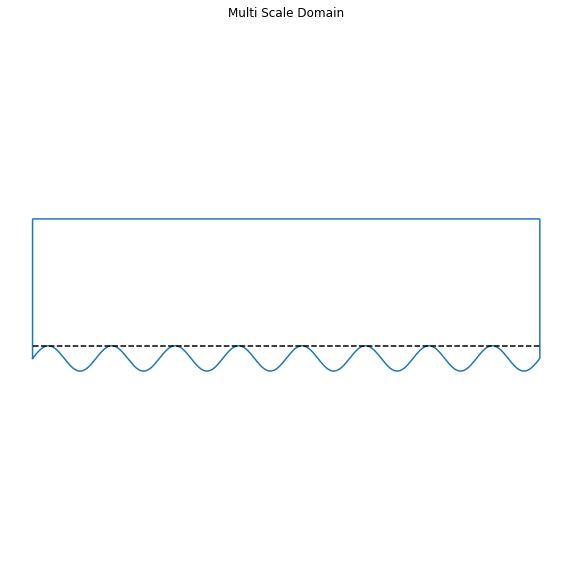

In [44]:
from hmm.stokes_scaled import StokesMacProb, StokesMicProb, trig_interp, StokesData, StokesHMMProblem
from hmm.stokes_scaled import MacroSolver, MicroSolver, IterativeHMMSolver
from util.plot_tools import *

eps = 0.05
k = 8*4#round(1 / eps / 2) * 3
dom = [[-1.,1.], [0.,0.5]]

Lx = dom[0][1] - dom[0][0]

Ac = 0.45
A = 1. #0.5
h = 1. #1.5
f = lambda x: eps * (-h + A * np.sin(k*x)) #1.6
df = lambda x: eps * k * np.cos(k*x) * A
ddf = lambda x: -eps * (k**2) * np.sin(k*x) * A
g = lambda x: dom[1][1]*(1 + np.sin(2*np.pi * x / Lx) * Ac)
#max(imag(z), 0) .* (1 + a3*sin(k3 * real(z)));
data = StokesData(f, df, ddf, g, dom)

plt.figure(figsize=(10,10))
plt.title("Multi Scale Domain")
data.plot(plt.gca())
remove_axes(plt.gca())
plt.axis("equal")

## Coupling to Micro Domain

To couple the macro domain to the microscopic domain, we make use of the HMM framework.
We construct a set of evenly spaced micro problems based on the Stokes data. The macro problem is constructed with a pre-specified resolution in the x- and y-directions.

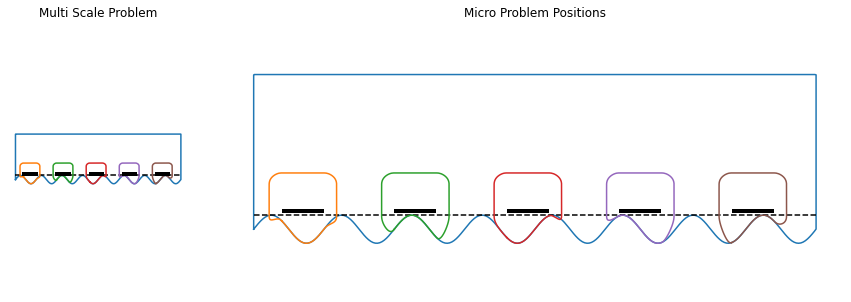

In [56]:
# Macro problem
xDim = 41
yDim = 43
iDeg = 13 #nMic*2 +1
macro = StokesMacProb(data, lambda x,a: trig_interp(x,a, iDeg, L=dom[0][1]-dom[0][0]))

# Micro problems
nMic = 5
xPos = np.linspace(dom[0][0]+4*eps, dom[0][1]-4*eps, nMic)-2*eps
micros = [StokesMicProb(data, x, 3*eps, 3*eps, 0.1) for x in xPos]

# Hmm problem.
hmm_prob = StokesHMMProblem(macro, micros, data)

## PLOT ##

plt.figure(figsize=(15,5))

plt.subplot2grid((1,4), (0,0), colspan=1)
plt.title("Multi Scale Problem")
hmm_prob.plot(plt.gca())
plt.axis("Equal")
remove_axes(plt.gca())

plt.subplot2grid((1,4), (0,1), colspan=3)
plt.title("Micro Problem Positions")
hmm_prob.plot(plt.gca())
plt.axis("Equal")
remove_axes(plt.gca())
#plt.xlim([-eps,1 + eps])
#plt.ylim([-1-1*eps, -1+6*eps])

## Solving using HMM iterations

To solve the problem, we make use of a sequence of micro solvers, as well as a micro solver.

In [57]:
class Callback():
    def __init__(self, macro):
        self.N = 100
        self.x = np.linspace(0,1,self.N)
        self.macro = macro
        self.current_alpha = macro.alpha(self.x)
        self.diff = []
    
    def __call__(self, it, macro_sol, micro_sols):
        self.previous_alpha = self.current_alpha
        self.current_alpha = self.macro.alpha(self.x)
        self.diff.append(np.linalg.norm(self.previous_alpha - self.current_alpha) / self.N**0.5)
        
debug_cb = Callback(macro)

print("Precomputing...")
macro_solver = MacroSolver(xDim, yDim)
micro_solvers = [MicroSolver(m) for m in micros]
hmm_solver = IterativeHMMSolver(macro_solver, micro_solvers)
print("Done")


print("HMM Solver...")
macro_guess = macro_solver.solve(macro)
(macro_sol, micro_sols) = hmm_solver.solve(hmm_prob, macro_guess=macro_guess, 
                                           callback=debug_cb, verbose=True, maxiter=7)
print("\nDone")

Precomputing...
Done
HMM Solver...
Step 6/7
Done


## Convergence study for slip coefficient

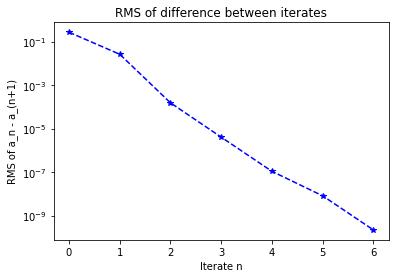

In [58]:
plt.figure()
plt.title("RMS of difference between iterates")
plt.semilogy(debug_cb.diff, 'b*--')
plt.xlabel("Iterate n")
plt.ylabel("RMS of a_n - a_(n+1)")

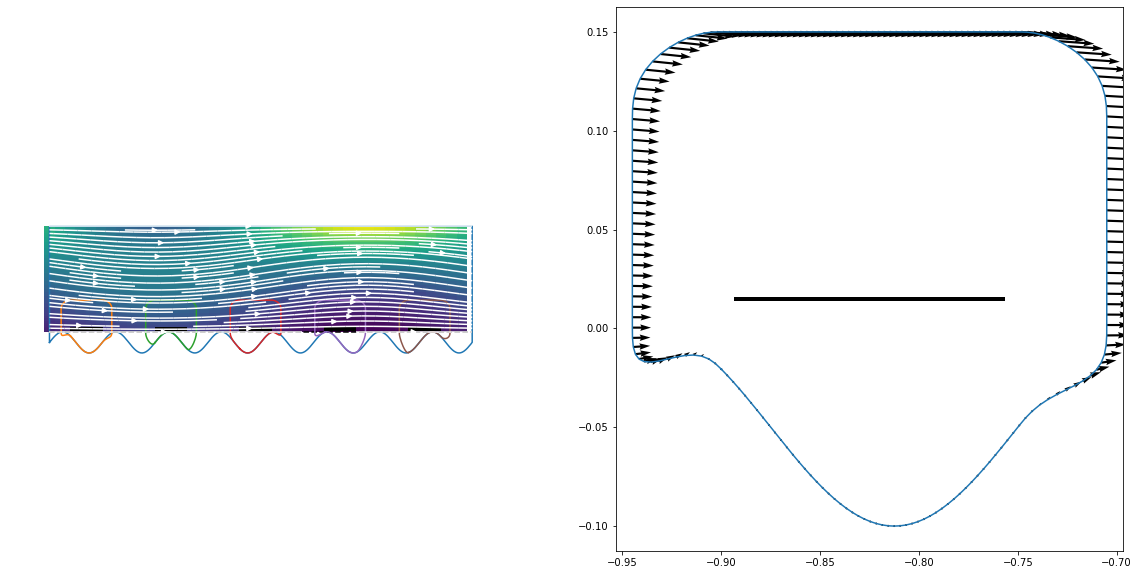

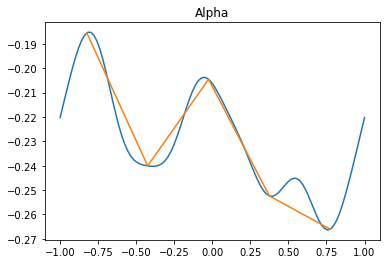

In [59]:
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.axis("equal")
hmm_prob.plot(plt.gca())
macro_sol.u.plot(plt.gca())
macro_sol.plot_stream(plt.gca(), color="white")
w = dom[0][1] - dom[0][0]
plt.xlim([dom[0][0]-0.1*w, dom[0][1]+0.1*w])
plt.ylim([dom[1][0]-0.1*w, dom[1][1]+0.1*w])

remove_axes(plt.gca())

plt.subplot(122)
micros[0].plot(plt.gca())
micros[0].geom.plot_field_on_boundary(plt.gca(), micros[0].condition)
plt.axis("equal")


plt.figure()
plt.title("Alpha")
x = np.linspace(dom[0][0],dom[0][1],100)
a = macro.alpha(x)
xm = np.array([sol.x for sol in micro_sols])
am = np.array([sol.alpha for sol in micro_sols])
plt.plot(x, a)
plt.plot(xm, am)
#print(macro.alpha)

#plt.figure(figsize=(10,6))
#plt.title("Condition")
#t = np.linspace(0,2*np.pi, 300)
#v = micros[0].condition(t)
#plt.plot(t, np.real(v))
#plt.plot(t, np.imag(v))
#plt.xlim([1,3])

0.45 0.05 8


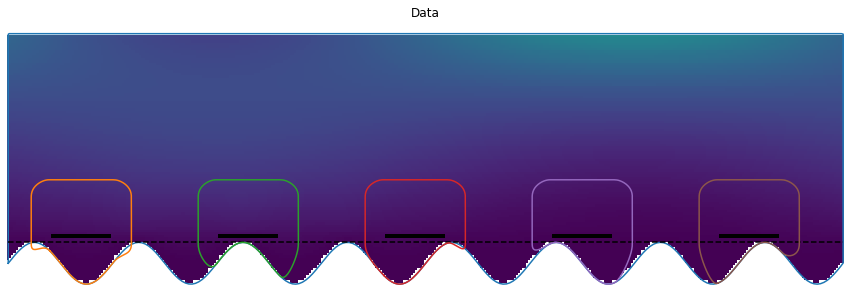

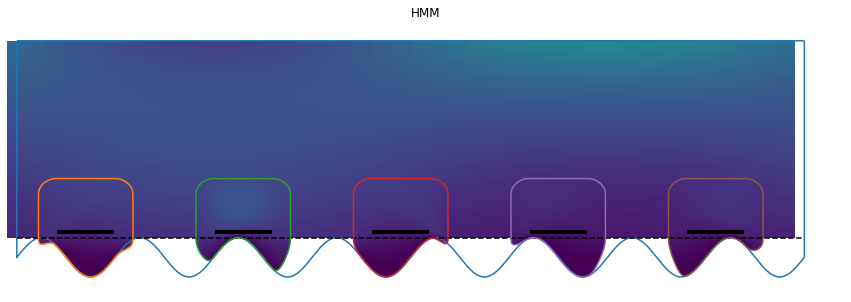

In [78]:
from boundary_solvers.gauss_grid_2d import StokesDirichletProblem
from scipy.io import loadmat
#from scipy.interpolate import interp2d
import matplotlib.pyplot as plt
from util.interp import PiecewiseInterp2D


matf = loadmat("/home/emastr/phd/data/reference/run_54.mat", struct_as_record=True)
info = matf['info'][0][0]
params = info['input_params'][0][0]
amp = params['amplitude_condition'].squeeze()
eps = params['amplitude_bottom'].squeeze()
nper = params['n_periods_bottom'].squeeze()
print(amp,eps,nper)

Uc = info['Uc']
Vc = info['Vc']
mask = np.isnan(Uc)

#plt.imshow(mask[::-1])

#Uc = np.where(mask, -np.ones_like(Uc), Uc)

x = np.linspace(-1,1,Uc.shape[0])
y = np.linspace(-1,1,Uc.shape[1])
X,Y = np.meshgrid(x,y)

#Uc = X + Y

row0, row1 = 150,301#200,301

xmac = x;
ymac = y[row0:row1]
Umac = Uc[row0:row1,:]
Xmac = X[row0:row1,:]
Ymac = Y[row0:row1,:]

Nx = 400
Ny = 100
pwlerp = PiecewiseInterp2D(xmac, ymac, Umac)
xhd = np.linspace(-1,1, Nx)
yhd = np.linspace(-0.1,0.5, Ny)
Xhd, Yhd = np.meshgrid(xhd, yhd)
Uhd = pwlerp(Xhd.flatten(),Yhd.flatten()).reshape((Ny, Nx))

vmax, vmin = 1.5, 0.

plt.figure(figsize=(15,5))
plt.title("Data")
plt.pcolormesh(Xhd, Yhd, Uhd, vmin=vmin, vmax=vmax)#, vmin=0, vmax=0.003)#, vmin=-0.5, vmax=0.5)#, vmin=-0.5, vmax=0.5)
plt.ylim([-0.2, 0.7])
plt.axis("equal")
remove_axes(plt.gca())
hmm_prob.plot(plt.gca())

plt.figure(figsize=(15,5))
plt.title("HMM")
macro_sol.u.plot(plt.gca(), vmin=vmin, vmax=vmax)
plt.ylim([-0.2, 0.7])
plt.axis("equal")
for m in micros:
    prob = StokesDirichletProblem(m.geom, m.condition)
    prob.solve()
    m.geom.plot_field(plt.gca(), lambda z: np.real(prob.evaluate(z)), apply_mask=True, vmin=vmin, vmax=vmax)
remove_axes(plt.gca())
hmm_prob.plot(plt.gca(), color='black', linewidth=1)




0.1138325431860148


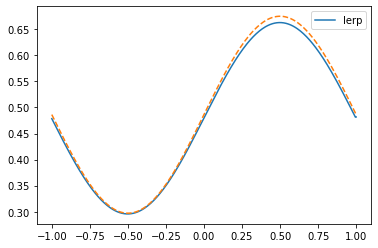

In [61]:
plt.figure()
yfix = dom[1][1]-np.ones_like(xhd)*0.02
#plt.plot(xmac, Umac[53,:], label='true')
plt.plot(xhd, pwlerp(xhd, yfix), label='lerp')#, linestyle='--')
plt.plot(xhd, macro_sol.u(xhd, yfix), linestyle='--')
plt.legend()

# a f(x) + b = g(x)
# a f(y) + b = g(y)
# a = (g(x) - g(y)) / (f(x) - f(y))
x1 = np.array([0.2,0.4])
y1 = np.zeros_like(x1) + 0.1
f = pwlerp(x1, y1)
g = macro_sol.u(x1, y1)

a = (g[0]-g[1]) / (f[0] - f[1])
b = g[0] - a*f[1]
print(b)


Verifying derivatives

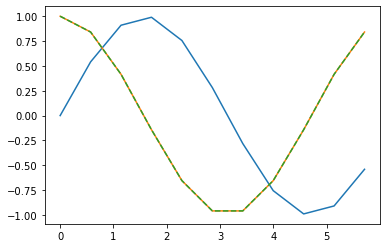

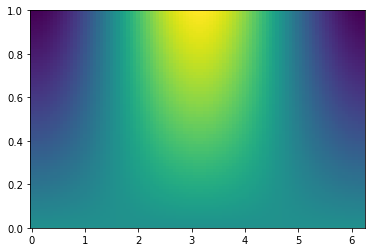

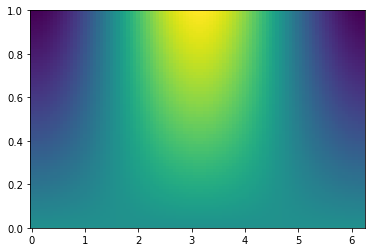

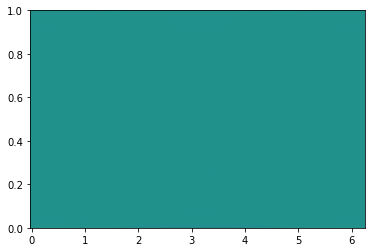

In [37]:
f = lambda x: np.sin(x)
df = lambda x: np.cos(x)

basis = SSBasis.fromFunction(f, 2*np.pi, 0, FourBasis, 11)
dbasis = SSBasis.fromFunction(df, 2*np.pi, 0, FourBasis, 11)
#basis = FourBasis.fromFunction(f, 11)


basis.plot(plt.gca(), 11)
dbasis.plot(plt.gca(), 11)
basis.diff(1).plot(plt.gca(), 11, linestyle='--')


#f = lambda x,y: np.sin(2*np.pi*x)*np.cos(2*np.pi*y)
f = lambda x,y: np.sin(x)*np.cos(y)
dx_f = lambda x,y: np.cos(x)*np.cos(y)
dxy_f = lambda x,y: -f(y,x)
scale = [2*np.pi,1.]
shift = [0.,0.]

#help(ScaleShiftedBasisProduct)
basis = SSBasisProduct.fromFunctionInDomain(f, [[0,2*np.pi], [0,1]], 
                                    101, 101, FourBasis, ChebBasis)
#basis = BasisProduct.fromFunction(f, 101, 101, FourBasis, ChebBasis)
dx_basis = basis.diff(1, 1)

plt.figure()
dx_basis.plot(plt.gca())


X, Y = basis.grid()
plt.figure()
plt.pcolormesh(X, Y, dxy_f(X,Y))

plt.figure()
plt.pcolormesh(X,Y,dxy_f(X,Y)-
               dx_basis.eval_grid())
